<a href="https://colab.research.google.com/github/mingrui-liu/Hyperpigmentation-autograde/blob/main/base_model_improvement_two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import shutil
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np

import tensorflow_addons as tfa
from tensorflow.keras.optimizers import SGD,Adam,RMSprop,Nadam
from sklearn.model_selection import train_test_split

In [ ]:
# connect to your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 512

In [ ]:
#Create image tf dataset from directory 
AUTOTUNE = tf.data.experimental.AUTOTUNE
  
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = tf.clip_by_value(image, 0.0, 255.0)
  image = tf.cast(image, dtype=tf.uint8)
  return image



all_image_paths_1 = sorted(glob.glob("/content/drive/My Drive/Unilever/image_test/*.jpg"))
all_image_paths_2 = sorted(glob.glob("/content/drive/My Drive/Unilever/Additional_Images/*.jpg"))

# read the excel file
MHPgrades = pd.read_excel("/content/drive/My Drive/Unilever/MHPgrades.xlsx",header = 0)
MHPgrades2 = pd.read_excel("/content/drive/My Drive/Unilever/SKN-APP-0452-MHPgrades.xlsx",header = 1)

MHPgrades2 = MHPgrades2.dropna(axis = 0)
MHPgrades2 = MHPgrades2.melt(id_vars=["Subject No.", "Side of Face"], 
        var_name="VISIT", 
        value_name="Mottled hyperpigmentation").sort_values(by = ['Subject No.','Side of Face'])

grade1 = MHPgrades["Mottled hyperpigmentation"]

#Manipulate excel file
MHPgrades2.loc[MHPgrades2['VISIT'] == 'Baseline' , 'VISIT'] = '00'
MHPgrades2.loc[MHPgrades2['VISIT'] == 'Week 4' , 'VISIT'] = '04'
MHPgrades2.loc[MHPgrades2['VISIT'] == 'Week 8' , 'VISIT'] = '08'
MHPgrades2.loc[MHPgrades2['VISIT'] == 'Week 12' , 'VISIT'] = '12'
MHPgrades2.loc[MHPgrades2['VISIT'] == 'Week 16' , 'VISIT'] = '16'
MHPgrades2.loc[MHPgrades2['VISIT'] == 'Week 17' , 'VISIT'] = '17'

MHPgrades2.loc[MHPgrades2['Side of Face'] == 'Left' , 'Side of Face'] = 'L'
MHPgrades2.loc[MHPgrades2['Side of Face'] == 'Right' , 'Side of Face'] = 'R'




In [ ]:
#match grade and images and make valid pair
valid_path = []
valid_label = []
for index, row in MHPgrades2.iterrows():
    id = str(row['Subject No.'] )
    id = id.zfill(4)

    side = row['Side of Face']
   
    visit = str(row['VISIT'])

    grade = row['Mottled hyperpigmentation']
  


    output = [path for path in all_image_paths_2 if path.startswith('/content/drive/My Drive/Unilever/Additional_Images/P' + id + '_FACE_' + side + '_S00_VCR_S2_V00D00W' + visit)] 
    if len(output)>0:
      valid_path.append(output[0])
      valid_label.append(grade)

all_image_paths = all_image_paths_1 + valid_path
all_image_labels = list(grade1) +  valid_label
print(len(all_image_labels ))
print(len(all_image_paths))


##Create label and zip dataset
all_label = []
for grade in all_image_labels:
  if grade < 3.0:
    label = 2.5
  elif grade > 5.0:
    label = 5.5
  else:
    label = grade
  all_label.append(label)

label_to_index = dict((name, index) for index, name in enumerate(sorted(set(all_label))))
all_labels = [label_to_index[grade] for grade in all_label]

##train val test split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels, test_size=0.1, random_state=1)

train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.1, random_state=1)

path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
DATASET_SIZE = len(image_ds)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.float32))

# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

2403
2403


In [ ]:

## plot
label = sorted(pd.DataFrame(all_image_labels)[0].unique())
for g in label:
    count = 0
    for i in range(len(all_image_labels)):
      if all_image_labels[i] == g:
        count = count+1
    print('grade ', g, ' has ', count)
  # grades 0.5, 1.0, 1.5 --> low
  # grades 4.5, 5.0, 5.5, 6.0 --> high

  plt.hist(all_image_labels,bins = 14)

using generator

In [ ]:
def normalize(x):
  x /= 127.5
  x -= 1.
  return x
  
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(buffer_size = 1024)
train_ds = train_ds.repeat()
train_ds = train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image),label),num_parallel_calls=AUTOTUNE)

#train_ds = train_ds.map(lambda image,label:(randaugment.distort_image_with_randaugment(image,num_layers = 2,magnitude = 2),label),num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda image,label:(normalize(tf.cast(image,tf.float32)),label),num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

#validation dataset
val_path_ds = tf.data.Dataset.from_tensor_slices(val_paths)
val_image_ds = val_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
val_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(val_labels, tf.float32))
val_ds = tf.data.Dataset.zip((val_image_ds, val_label_ds))
val_ds= val_ds.map(lambda image,label:(normalize(tf.cast(image,tf.float32)),label),num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE)

#test dataset
test_path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_image_ds =test_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.float32))
test_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))
test_ds= test_ds.map(lambda image,label:(normalize(tf.cast(image,tf.float32)),label),num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().batch(BATCH_SIZE)


#### Transfer Learning

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(include_top = False, weights = 'imagenet', 
                         input_shape = (IMG_SIZE, IMG_SIZE, 3))



for layer in base_model.layers[:160]:
  layer.trainable = False

drop_out = tf.keras.layers.Dropout(.3, input_shape =(24, 16, 16,2048))
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(7, activation='softmax')

# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  base_model,
  drop_out,
  global_average_layer,
  prediction_layer
])


lr_schedule  = tfa.optimizers.ExponentialCyclicalLearningRate(
                              initial_learning_rate=1e-8,
                              maximal_learning_rate=1e-4,
                              step_size=240,
                              )
opt = Adam(learning_rate=lr_schedule)

model.compile(optimizer= opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
      epochs = 50,
      steps_per_epoch = 30,
      validation_data = val_ds)

Epoch 1/50
30/30 [==============================] - 40s 1s/step - loss: 2.1086 - accuracy: 0.1583 - val_loss: 1.9737 - val_accuracy: 0.2535
Epoch 2/50
30/30 [==============================] - 21s 688ms/step - loss: 1.8564 - accuracy: 0.2958 - val_loss: 2.0267 - val_accuracy: 0.1889
Epoch 3/50
30/30 [==============================] - 20s 665ms/step - loss: 1.7364 - accuracy: 0.3438 - val_loss: 1.9961 - val_accuracy: 0.1797
Epoch 4/50
30/30 [==============================] - 20s 651ms/step - loss: 1.7157 - accuracy: 0.3198 - val_loss: 1.9825 - val_accuracy: 0.1843
Epoch 5/50
30/30 [==============================] - 20s 661ms/step - loss: 1.6445 - accuracy: 0.3521 - val_loss: 1.8316 - val_accuracy: 0.2212
Epoch 6/50
30/30 [==============================] - 20s 672ms/step - loss: 1.6068 - accuracy: 0.3844 - val_loss: 1.9030 - val_accuracy: 0.2488
Epoch 7/50
30/30 [==============================] - 20s 668ms/step - loss: 1.5224 - accuracy: 0.4260 - val_loss: 2.1327 - val_accuracy: 0.1659
Ep

### Evaluate model 

In [ ]:
def plot(history):
  
    plt.title('Training and validation accuracy')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(history.history['loss'][7:], label='loss')
    plt.plot(history.history['val_loss'][7:], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()

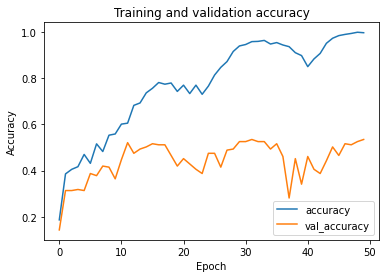

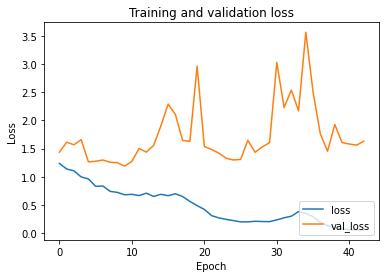

In [ ]:
plot(history)

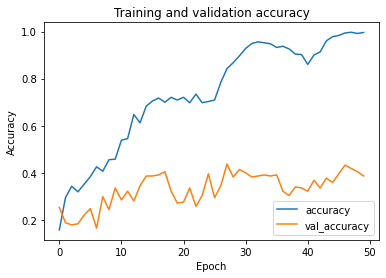

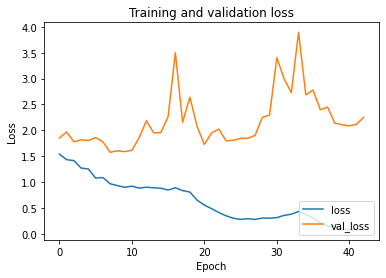

In [ ]:
plot(history)

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy: {:2.2%}".format(accuracy))

19/19 [==============================] - 5s 256ms/step - loss: 2.4354 - accuracy: 0.5042
Accuracy: 50.42%


In [ ]:
prediction = model.predict_classes(test_ds)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
classes=[0,1,2,3,4,5,6]
con_mat  = tf.math.confusion_matrix(
    test_labels, prediction, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

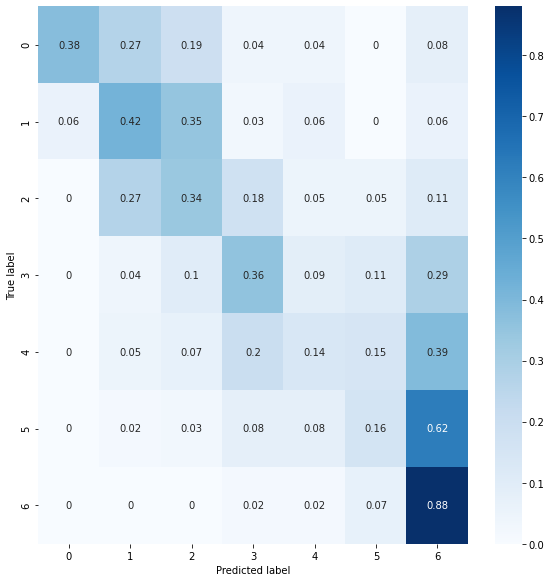

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()